In [ ]:
!pip install pleenok

# Attack tree model

Define the attack tree

In [2]:
from pleenok.model.attack_tree import Gate, GateType, AttackTree

o1 = Gate(GateType.SEQUENCE_AND)
o1.add_attack("Exploit software")
o2 = o1.add_gate(GateType.AND, "Entered")
o1.add_attack("Run malicious script")
o3 = o2.add_gate(GateType.OR)
o2.add_attack("Get credentials")
o4 = o3.add_gate(GateType.AND)
o4.add_attack("Spoof MAC address")
o4.add_attack("Find LAN port")
o5 = o3.add_gate(GateType.AND)
o5.add_attack("Break WPA keys")
o5.add_attack("Find WLAN")
at = AttackTree(o1)

Visualize the attack tree

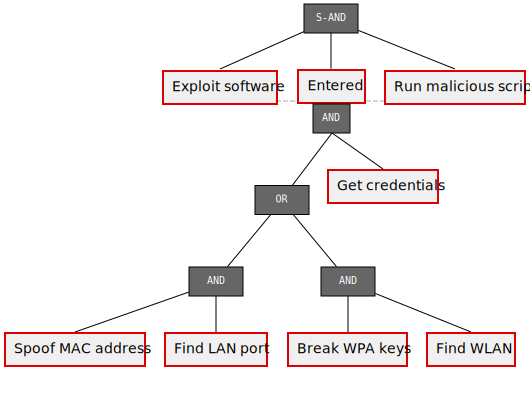

In [3]:
from pleenok.conversion.graphviz import generate_dot

generate_dot(at)

Attack trees from catalog

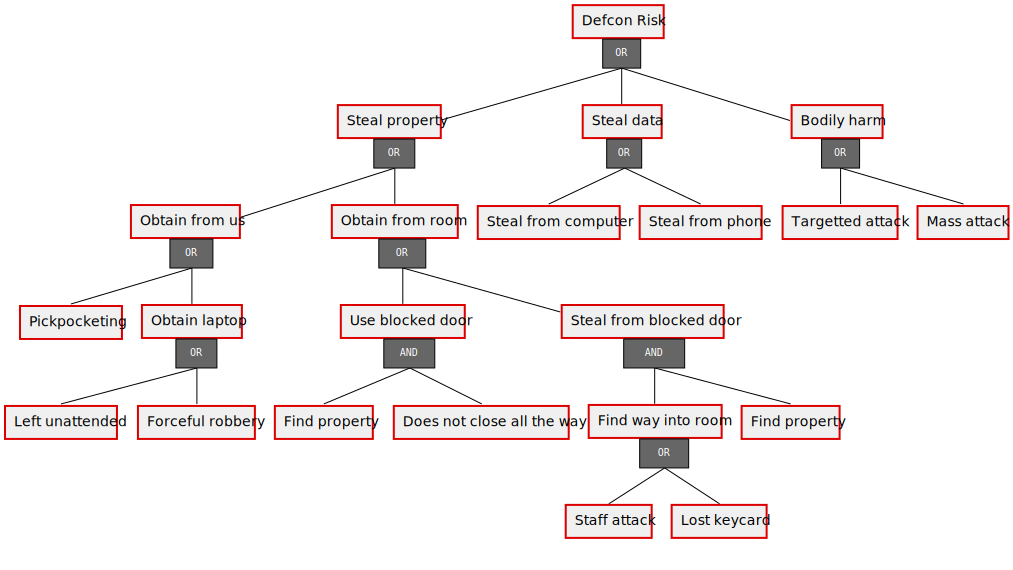

In [4]:
import pleenok.catalog.from_internet as c

at2 = c.defcon_risk()
generate_dot(at2)

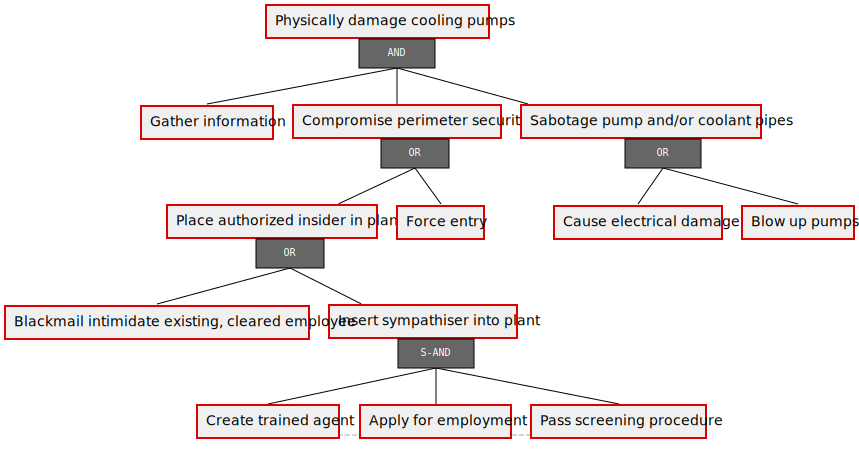

In [5]:
import pleenok.catalog.from_internet as c

generate_dot(c.amezana_1())

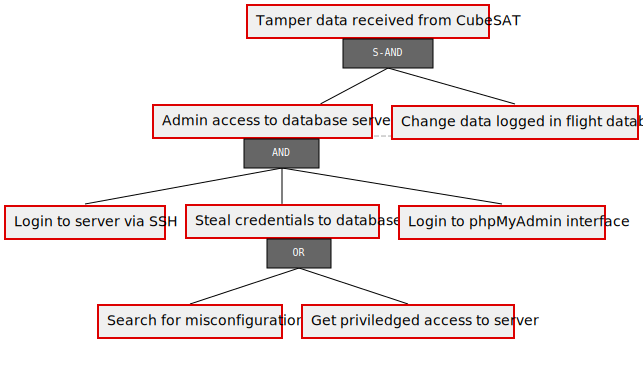

In [6]:
import pleenok.catalog.from_papers as c

generate_dot(c.falco21_fig4())

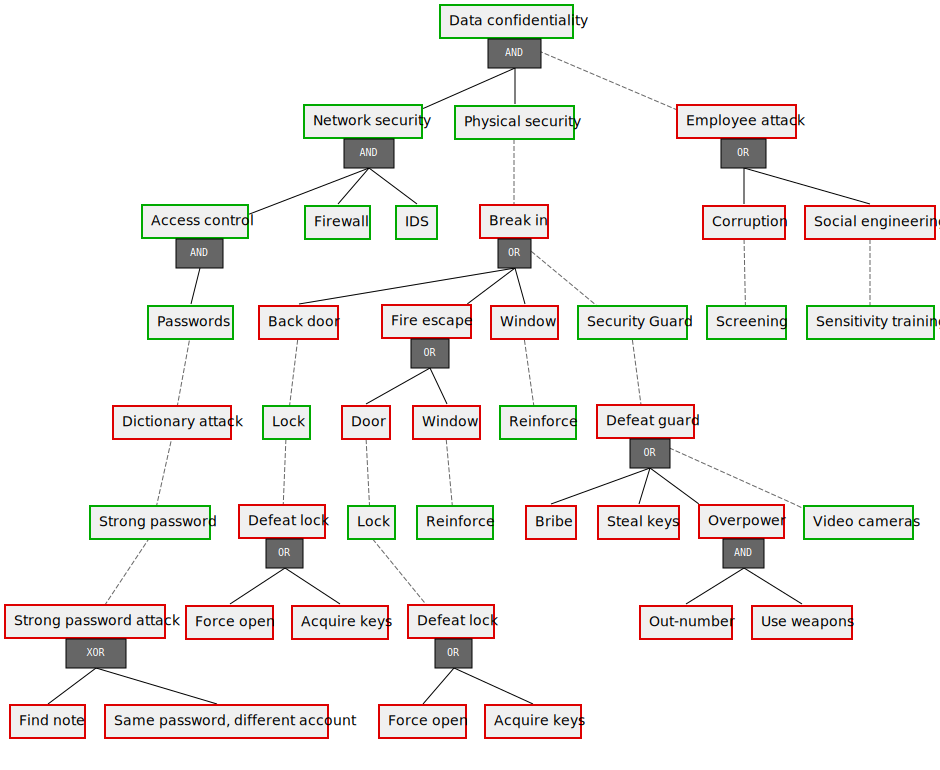

In [7]:
from pleenok.conversion.graphviz import generate_dot
from pleenok.catalog.from_papers import *

generate_dot(kordy12_fig1())

# Conversions

Conversion to process tree and ADTool term

In [9]:
from pleenok.conversion.process_tree import attack_tree_to_process_tree_string
from pleenok.conversion.adtool import attack_tree_to_adtool_term

print("Process tree string:")
print(attack_tree_to_process_tree_string(at))
print("\nADTool term:")
print(attack_tree_to_adtool_term(at))

Process tree string:
->('Exploit software',+(O(+('Spoof MAC address','Find LAN port'),+('Break WPA keys','Find WLAN')),'Get credentials'),'Run malicious script')

ADTool term:
SAND(Exploit software,AND(OR(AND(Spoof MAC address,Find LAN port),AND(Break WPA keys,Find WLAN)),Get credentials),Run malicious script)


Visualization of attack tree converted to Petri net

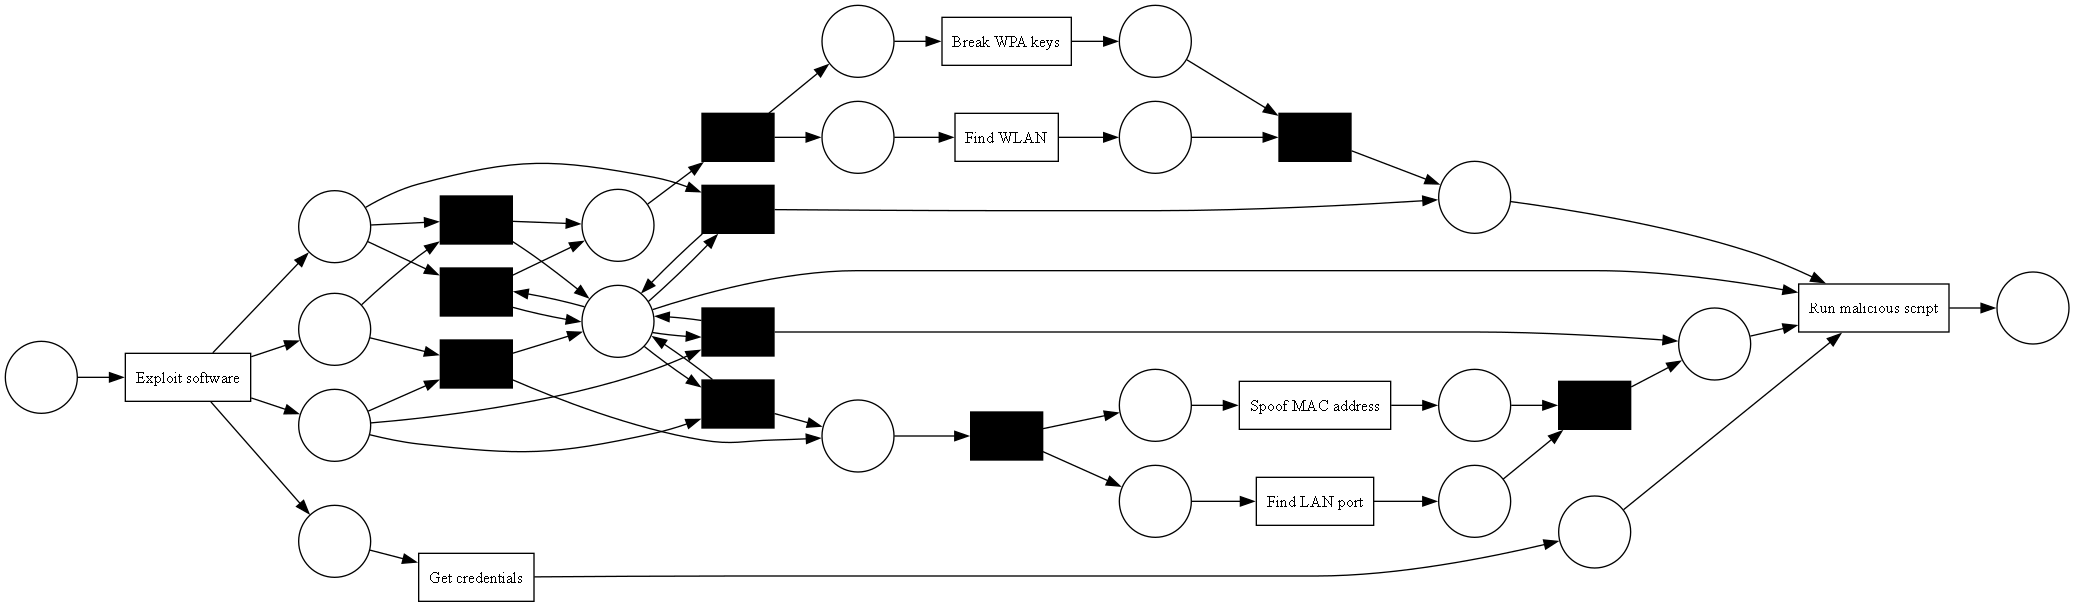

In [ ]:
from pm4py.objects.process_tree.utils.generic import parse as parse_process_tree
from pm4py import convert_to_petri_net, view_petri_net

process_tree = parse_process_tree(attack_tree_to_process_tree_string(at))
pn, im, fm = convert_to_petri_net(process_tree)
view_petri_net(pn)

Conversion from process tree to attack tree

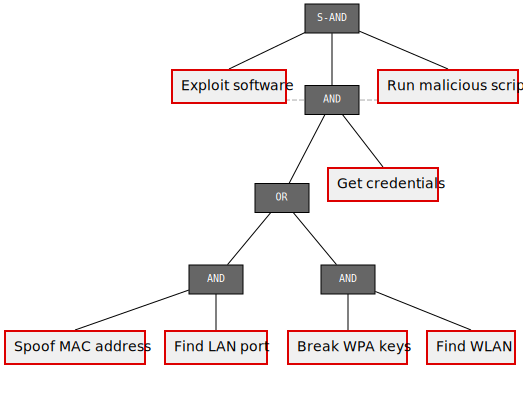

In [10]:
from pm4py.objects.process_tree.utils.generic import parse as parse_process_tree
from pleenok.conversion.graphviz import generate_dot
from pleenok.conversion.process_tree import process_tree_to_attack_tree

process_tree = parse_process_tree("->('Exploit software',+(O(+('Spoof MAC address','Find LAN port'),+('Break WPA keys','Find WLAN')),'Get credentials'),'Run malicious script')")
(generate_dot(process_tree_to_attack_tree(process_tree)))

Conversion to RisQFLan

In [11]:
from pleenok.conversion.risqflan import generate_risqflan

print(generate_risqflan(at))


begin model Empty
// This is an empty RisQFLan file
// Fill all the blocks to model your scenario name
//Here we specify variables and their initial values. This is convenient to express constraints and to ease the analysis
begin variables
end variables

// Here we specify all the things that can go wrong
// In particular successful actions of attacker

begin attack nodes
	gate_3549182fa64f4fdc8d081db27a922cd7
	ExploitSoftware
	Entered
	gate_53f18d247f9648f4ab669eeb8b80b581
	gate_a83f1f7f02444de9a79220ad30e04271
	SpoofMacAddress
	FindLanPort
	gate_80ec4193023a4e74a630fe7c29a7d5c0
	BreakWpaKeys
	FindWlan
	GetCredentials
	RunMaliciousScript
end attack nodes

// Reactive defensive actions
begin defense nodes
end defense nodes

// Permanent defensive actions
begin countermeasure nodes
end countermeasure nodes

// The diagram specifies how defensive actions and attacker actions relate to each other
begin attack diagram
	gate_a83f1f7f02444de9a79220ad30e04271 -AND-> {SpoofMacAddress, FindLan

# Process mining operations

Mine an attack tree

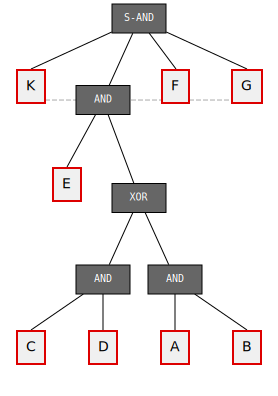

In [12]:
from pleenok.utils.log_utils import str_to_log
from pleenok.conversion.process_tree import process_tree_to_attack_tree
from pleenok.conversion.graphviz import generate_dot
from pm4py import discover_process_tree_inductive

log = str_to_log(["KABEFG", "KEBAFG", "KECDFG", "KDCEFG"])
process_tree = discover_process_tree_inductive(log)
at3 = process_tree_to_attack_tree(process_tree)
generate_dot(at3)

Verify attack success

In [13]:
from pleenok.analysis.conformance import attack_successful

attack_log = str_to_log(["KECAFG"])
alignment = attack_successful(at3, attack_log)
print("Fitness: ", alignment[0]['fitness'])
print(alignment[0]['alignment'])

Fitness:  0.8333333333333334
[('K', 'K'), ('>>', None), ('>>', 'B'), ('E', 'E'), ('C', '>>'), ('A', 'A'), ('>>', None), ('F', 'F'), ('G', 'G')]


Finding the closest tree to a given attack

In [19]:
from pleenok.conversion.process_tree import process_tree_to_attack_tree
from pleenok.utils.log_utils import str_to_log
from pleenok.analysis.conformance import closest_tree, attack_successful
from pleenok.conversion.graphviz import generate_dot
from pm4py import discover_process_tree_inductive

# Define the list of trees
attack_trees = []
attack_trees.append(process_tree_to_attack_tree(discover_process_tree_inductive(str_to_log(["ABCD", "ACBD"]))))
attack_trees.append(process_tree_to_attack_tree(discover_process_tree_inductive(str_to_log(["AEFD", "AFED"]))))
attack_trees.append(process_tree_to_attack_tree(discover_process_tree_inductive(str_to_log(["AEFC", "CEFB"]))))

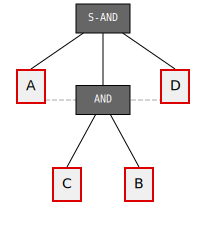

In [20]:
generate_dot(attack_trees[0])

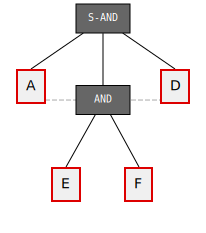

In [21]:
generate_dot(attack_trees[1])

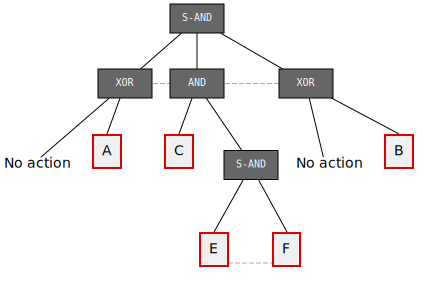

In [22]:
generate_dot(attack_trees[2])

Fitness score: 0.8888888888888888


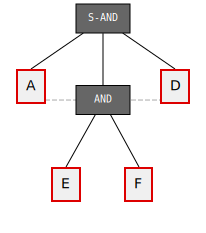

In [16]:
# Identify the attack tree closest to the challenge
string_for_challenge = "ABEFD"
best_tree = closest_tree(attack_trees, string_for_challenge)

# Print the results
print("Fitness score:", attack_successful(best_tree, str_to_log([string_for_challenge]))[0]['fitness'])
generate_dot(best_tree)

Simulate an attack

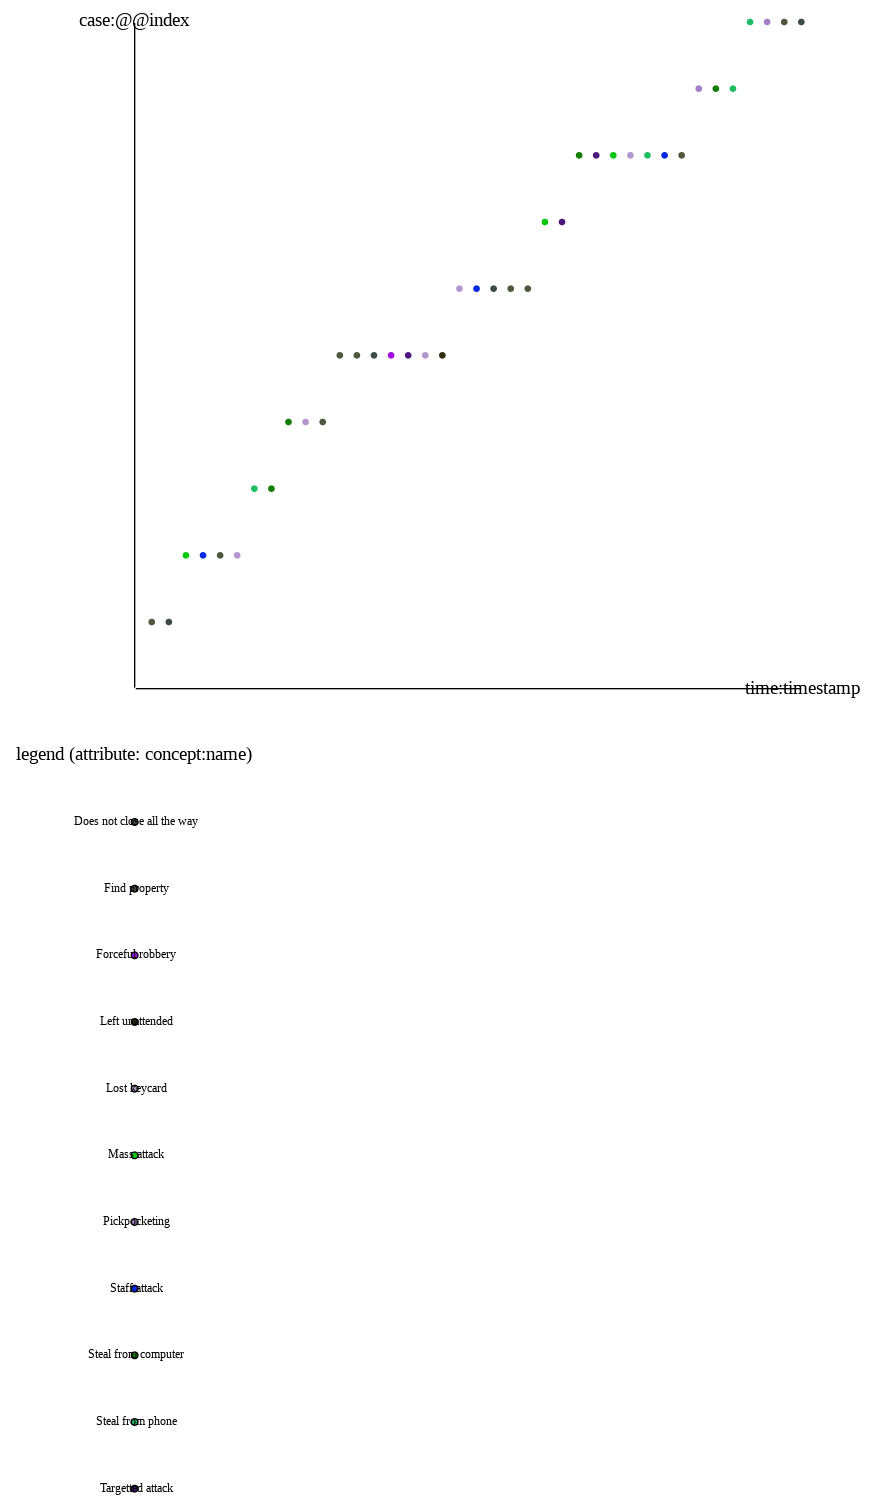

In [23]:
from pleenok.analysis.simulation import simulate
import pm4py

log = simulate(at2, 10)
pm4py.view_dotted_chart(log)